In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

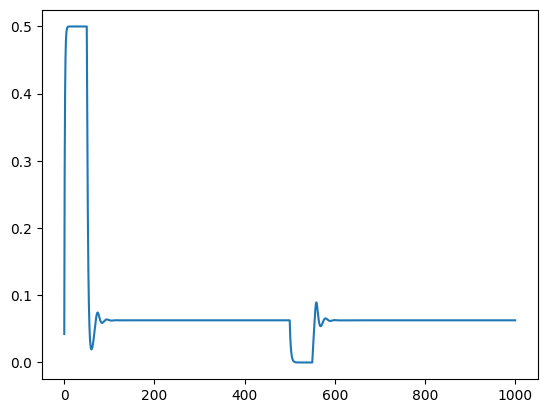

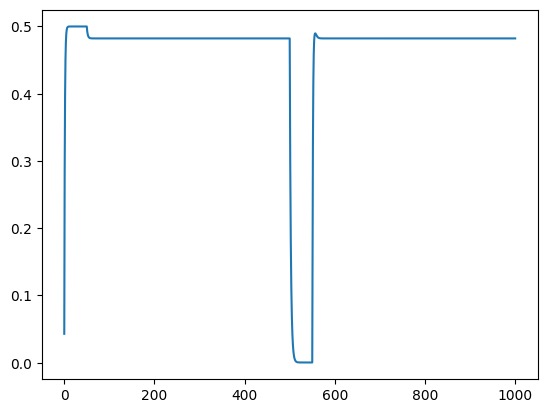

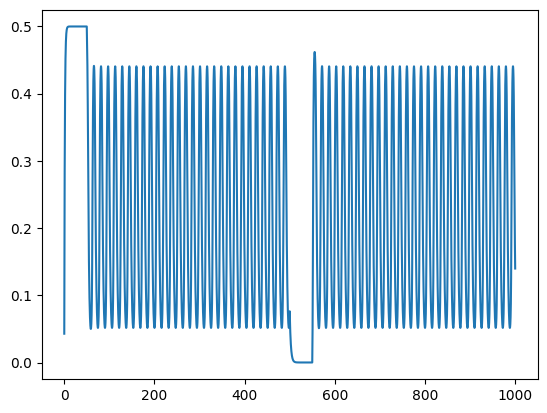

period =  15.67777777777778


In [3]:
comp_points = [[1., 0.5], [3., 0.5], [2., 0.5]]

N = 1
colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

model = WCModel()

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params.signalV = 1.

zero_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
rect_input = np.vstack( (zero_input)*2 )
rect_input[0,:500] = 5.
rect_input[0,5000:5500] = -5.

for p in comp_points:
    model.params["exc_ext"] = p[0] + rect_input[0,:]
    model.params["inh_ext"] = p[1]
    model.run()

    for n in range(N):
        plt.plot(model.t, model.exc[n,:], color=colors[n])
    plt.show()

    if p[0] == 2.:

        peaks = scipy.signal.find_peaks(model.exc[0,2000:5000])[0]
        plist = []
        for pind in range(1, len(peaks)):
            plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

        period = np.mean(plist)
        print("period = ", period)


In [5]:
def getperiods(x, target_period, duration):
    timing_list = [None] * N
    periods_list = [None] * N

    npeaks = np.floor(duration / target_period)

    for n in range(N):
        prom = 10.

        while True:
            timing_list[n] = scipy.signal.find_peaks(x[n, 0, 300:], prominence=prom)[0]
            if prom < 1e-6:
                break
            if len(timing_list[n]) < npeaks:
                prom *= 0.8
            else: break    
        
        periods_list[n] = []
        if len(timing_list[n]) < 3:
            continue
        for pind in range(1, len(timing_list[n])):
            periods_list[n].append(model.params.dt * (timing_list[n][pind]-timing_list[n][pind-1]))

    return timing_list, periods_list

In [217]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 300.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

target_array = [12., 20., 28.]
w2 = 1e-5

results = dict()
results["controls"] = [ [None, None, None], 
                        [None, None, None], 
                        [None, None, None], 
]
results["periods"] = [ [None, None, None], 
                        [None, None, None], 
                        [None, None, None], 
]
results["ftol_good"] = [ [None, None, None], 
                        [None, None, None], 
                        [None, None, None], 
]

(1, 3001) (1, 2, 3001) (1, 2, 3001)


In [279]:
it = 500
pr = np.arange(0,501,50)
maxstr = 10.
nmaxdel = model.getMaxDelay()

init_control = zero_control.copy()
dir = "images_1n"

# 1e-5: vanishing gradient

In [280]:
for pind in range(len(comp_points)):

    print("pind = ", pind)

    p = comp_points[pind]
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext"] = test_input + p[0]
    model.params["inh_ext"] = test_input + p[1]
    model.run()

    einit = np.zeros((N, nmaxdel+1))
    iinit = np.zeros((N, nmaxdel+1))


    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration

    model.params["exc_ext"] = zero_control[:,0,:] + p[0]
    model.params["inh_ext"] = zero_control[:,0,:] + p[1]

    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit
    model.run()

    for itar in range(len(target_array)):

        print("itar = ", itar)

        target_period = target_array[itar]
        i00 = 0
        int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
        while int0 > 25/dt:
            i00 += 1
            int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.            

        if type(results["controls"][pind][itar]) != type(None):
            model_controlled.control = results["controls"][pind][itar].copy()
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][itar] = model_controlled.control.copy()

        timings, periods = getperiods(model_controlled.get_xs(), target_period, duration)
        results["periods"][pind][itar] = periods

        fname = str(pind) + "_" + str(itar) + ".png"
        #plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control, filename= os.path.join(dir, fname))

pind =  0
itar =  0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.22315988148834398
Converged in iteration 2 with cost -0.22315988148834398
Final cost : -0.22315988148834398
itar =  1
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2675550245865294
Cost in iteration 50: -0.26755580750193725
Cost in iteration 100: -0.2675564216972118
Cost in iteration 150: -0.2675571067907641
Cost in iteration 200: -0.26755781994382277
Cost in iteration 250: -0.2675591322746536
Cost in iteration 300: -0.267560696719073
Cost in iteration 350: -0.26756198309136514
Cost in iteration 400: -0.26756295870789354
Cost in iteration 450: -0.2675638429111339
Cost in iteration 500: -0.267564777486978
Final cost : -0.267564777486978
pind =  1
itar =  0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.225224535265505
Cost

In [245]:
with open('osc_1n.pickle', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
with open('osc_1n.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings'])


In [236]:
xl = [ "Down", "Up", "Osc" ]

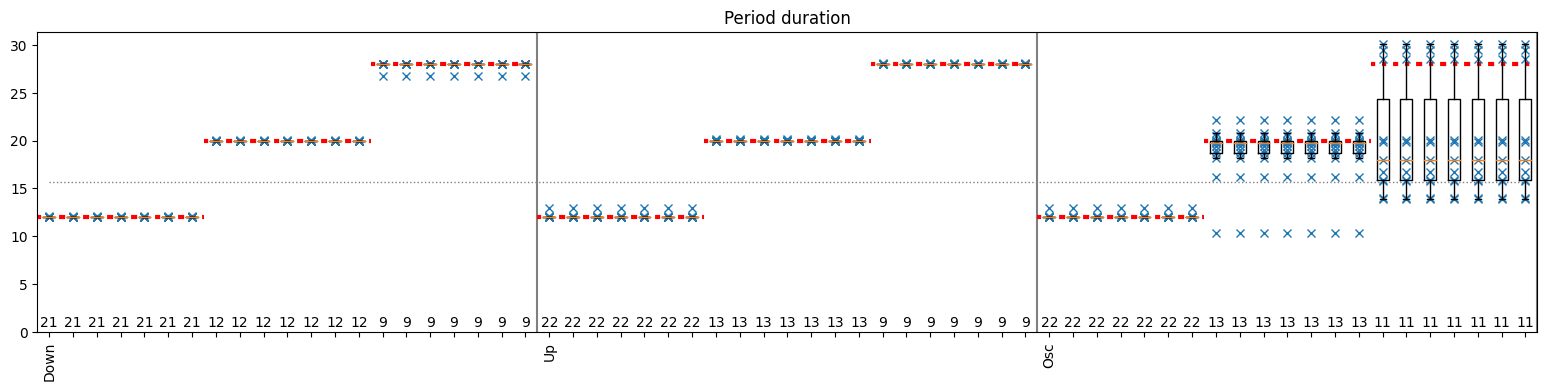

In [237]:
ydata = []
xlabels = []
fig = plt.figure(figsize =(15, 3))
ax = fig.add_axes([0, 0, 1, 1])

xpos = 0

for pind in range(len(comp_points)):
    for itar in range(len(target_array)):
        target_period = target_array[itar]

        for idt in range(len(ftol_array)):

            if [itar, idt] != [0, 0]:
                xlabels.append("")
            else:
                xlabels.append(xl[pind])

            data = results["periods"][pind][itar]
            ydata_ = []
            
            if data is None:
                ydata.append(ydata_)
                xpos += 1
                continue

            n_datapoints = 0

            for n in range(N):
                n_datapoints += len(data[n])
                
                if len(data[n]) != 0:
                    for dpoint in data[n]:
                        ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                        ydata_.append(dpoint)

            ydata.append(ydata_)

            ax.text(xpos+1, 1, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
            ax.hlines(target_period, xpos+0.5, xpos+1.5, linestyle=":", color="red", linewidth =3)

            xpos += 1

    ax.vlines(xpos+0.5, 0., 2.*period, color="grey")

ax.boxplot(ydata, showfliers=False)
ax.hlines(period, 1., len(xlabels), linestyle=":", color="grey",linewidth = 1)
ax.set_xticklabels(xlabels, rotation=90)
ax.set_ylim(0., 2.*period)
ax.set_title(r"Period duration")
plt.show()
fig.savefig(os.path.join(dir, "periods.png"), bbox_inches='tight')